------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis/blob/main/code.ipynb)__ 
------------------------------------------------------------------------------------------------------------------------

In [1]:
#this line imports the functions needed for this project
%run code.ipynb

# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [2]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [3]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (simple_common_stations(simple_common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['02261', '01639', '02601', '05371', '00691', '01550', '04104', '03032', '01975', '04887', '00701', '02290', '04371', '03730', '05906', '05705', '01691', '02597', '02014', '00867', '05100', '00656', '03631', '05792']


### Let's plot the stations to make sure that the points are representative for whole Germany:

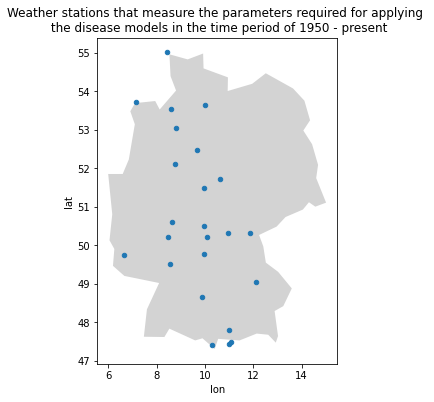

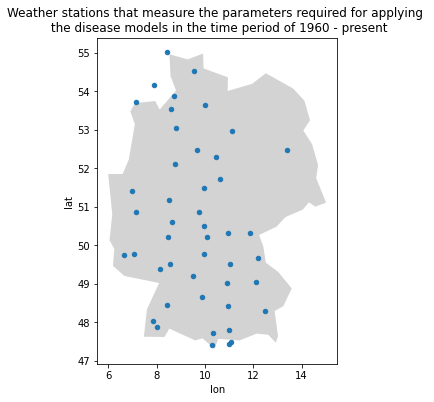

In [4]:
plot_points_germany(1950)
plot_points_germany(1960)


#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

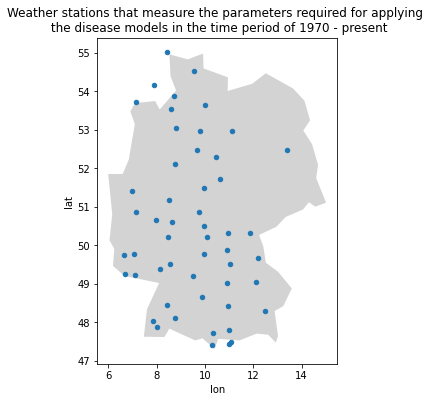

In [5]:
plot_points_germany(1970)


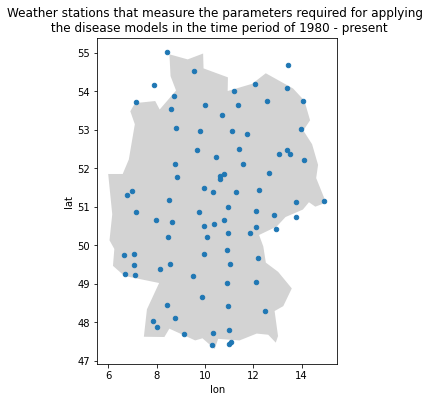

In [6]:
plot_points_germany(1980)

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

## Step 2. Results
### 1. Temperature

In [7]:
df = create_df("air_temperature","hourly",1950,2020,ids = common_ids, is_test=False)

FOUND stundenwerte_TU_01691_19480101_20211231_hist.zip FOUND stundenwerte_TU_00691_19490101_20211231_hist.zip FOUND stundenwerte_TU_04104_19480101_20211231_hist.zip FOUND stundenwerte_TU_02261_19480101_20211231_hist.zip FOUND stundenwerte_TU_00701_19490101_20211231_hist.zip FOUND stundenwerte_TU_01639_19500101_20211231_hist.zip FOUND stundenwerte_TU_02601_19480101_20211231_hist.zip FOUND stundenwerte_TU_02014_19490101_20211231_hist.zip FOUND stundenwerte_TU_02597_19480101_20211231_hist.zip FOUND stundenwerte_TU_00867_19470101_20211231_hist.zip FOUND stundenwerte_TU_05100_19410101_20211231_hist.zip FOUND stundenwerte_TU_04371_19500101_20211231_hist.zip FOUND stundenwerte_TU_03032_19490101_20211231_hist.zip FOUND stundenwerte_TU_05705_19480101_20211231_hist.zip FOUND stundenwerte_TU_00656_19480101_20211231_hist.zip FOUND stundenwerte_TU_01975_19490101_20211231_hist.zip FOUND stundenwerte_TU_02290_19470101_20211231_hist.zip FOUND stundenwerte_TU_05792_19500101_20211231_hist.zip FOUND stun

<AxesSubplot:xlabel='decade'>

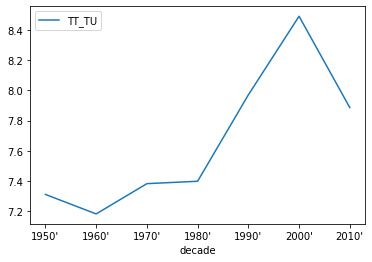

In [8]:
df = df[df["year"] >= 1950]
df = df[df["year"] <= 2019]
df["decade"] = df["year"].apply(lambda x: str(x)[:3]+"0'")
new_df = df.groupby("decade").mean()
new_df.plot( y = 'TT_TU')


Temperature has increased during the last 30 years. However, how does this reflect in plant disease optimal temperature development ?

In [9]:
df["useful_t"] = df.TT_TU.apply(lambda x: 1 if (x >= 15 and x <= 25) else 0)

<AxesSubplot:xlabel='decade'>

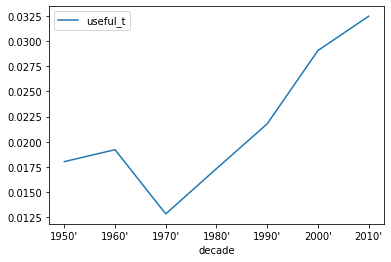

In [10]:

new_df = df[df["month"].isin([12,1,2,3,4])]
new_df= new_df.groupby("decade").mean()
new_df.plot( y = 'useful_t')

I will try now to attempt to model using CO2 emmisions:

https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions

### 2. Leaf wetness

In [11]:
#df1 = create_df("dew_point","hourly",1950,2020,ids = common_ids, is_test=False)
#df2= create_df("air_temperature","hourly",1950,2020,ids = common_ids, is_test=False)
df3= create_df("moisture","hourly",1950,2020,ids = common_ids, is_test=False)

FOUND stundenwerte_TF_03631_19490101_20211231_hist.zip FOUND stundenwerte_TF_02601_19490101_20211231_hist.zip FOUND stundenwerte_TF_05705_19490101_20211231_hist.zip FOUND stundenwerte_TF_01975_19490101_20211231_hist.zip FOUND stundenwerte_TF_02290_19490101_20211231_hist.zip FOUND stundenwerte_TF_00691_19490101_20211231_hist.zip FOUND stundenwerte_TF_04371_19501001_20211231_hist.zip FOUND stundenwerte_TF_00867_19490101_20211231_hist.zip FOUND stundenwerte_TF_01550_19490101_20211231_hist.zip FOUND stundenwerte_TF_05100_19490101_20211231_hist.zip FOUND stundenwerte_TF_04104_19490101_20211231_hist.zip FOUND stundenwerte_TF_03730_19490101_20211231_hist.zip FOUND stundenwerte_TF_02261_19490101_20211231_hist.zip FOUND stundenwerte_TF_00701_19490101_20211231_hist.zip FOUND stundenwerte_TF_01639_19490101_20211231_hist.zip FOUND stundenwerte_TF_01691_19501001_20211231_hist.zip FOUND stundenwerte_TF_03032_19490101_20211231_hist.zip FOUND stundenwerte_TF_02597_19490101_20211231_hist.zip FOUND stun

In [12]:
#print(df1.head())
df3 = df3[df3["year"] >= 1950]
df3 = df3[df3["year"] <= 2019]
df3["decade"] = df3["year"].apply(lambda x: str(x)[:3]+"0'")
print(df3.head())
"""
new_df2 = df2[df2["month"].isin([12,1,2,3,4])]
new_df2["lw1"]=df2["RF_TU"].apply(lambda x: 1 if x >=90 else 0)
new_df2= new_df2.groupby("decade").mean()
new_df2.plot( y = 'lw1')
#print(df3.head())
"""

     STATIONS_ID  MESS_DATUM  QN_8  ABSF_STD  VP_STD  TF_STD   P_STD  TT_STD  \
2905       03631  1950010100     3       3.6     4.5    -2.1  1011.9    -1.0   
2906       03631  1950010103     3       3.6     4.5    -2.7  1011.9    -2.0   
2907       03631  1950010106     3       3.6     4.5    -2.7  1011.9    -2.0   
2908       03631  1950010109     3       3.6     4.5    -2.7  1011.9    -2.0   
2909       03631  1950010112     3       3.6     4.5    -0.8  1011.9     1.0   

      RF_STD  TD_STD  eor  year  month  day  hour decade  
2905    80.0    -4.0  eor  1950      1    1     0  1950'  
2906    86.2    -4.0  eor  1950      1    1     3  1950'  
2907    86.2    -4.0  eor  1950      1    1     6  1950'  
2908    86.2    -4.0  eor  1950      1    1     9  1950'  
2909    69.2    -4.0  eor  1950      1    1    12  1950'  


'\nnew_df2 = df2[df2["month"].isin([12,1,2,3,4])]\nnew_df2["lw1"]=df2["RF_TU"].apply(lambda x: 1 if x >=90 else 0)\nnew_df2= new_df2.groupby("decade").mean()\nnew_df2.plot( y = \'lw1\')\n#print(df3.head())\n'

In [29]:
new_df3 = df3[df3["month"].isin([12,1,2,3,4])]
new_df3.drop(["QN_8","eor","ABSF_STD","VP_STD","TF_STD","P_STD","TT_STD"], inplace=True,axis=1)
print(new_df3.head())


     STATIONS_ID  MESS_DATUM  RF_STD  TD_STD  year  month  day  hour decade
2905       03631  1950010100    80.0    -4.0  1950      1    1     0  1950'
2906       03631  1950010103    86.2    -4.0  1950      1    1     3  1950'
2907       03631  1950010106    86.2    -4.0  1950      1    1     6  1950'
2908       03631  1950010109    86.2    -4.0  1950      1    1     9  1950'
2909       03631  1950010112    69.2    -4.0  1950      1    1    12  1950'


/var/folders/yd/1zxj_l9n3b31td3r6z9lbz9m0000gp/T/ipykernel_1892/1881095437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3.drop(["QN_8","eor","ABSF_STD","VP_STD","TF_STD","P_STD","TT_STD"], inplace=True,axis=1)


In [26]:
#new_df3 = df3[df3["month"].isin([12,1,2,3,4])]


/var/folders/yd/1zxj_l9n3b31td3r6z9lbz9m0000gp/T/ipykernel_1892/3019793885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df3["lw1"]=new_df3["RF_STD"].apply(lambda x: 1 if x >=90 else 0)


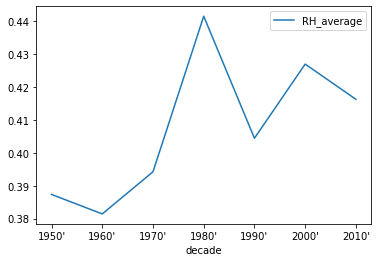

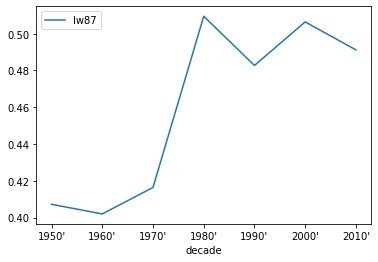

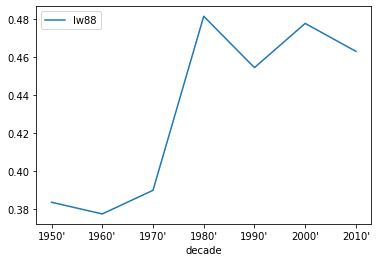

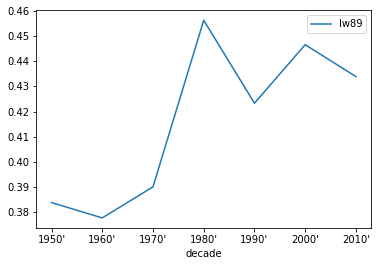

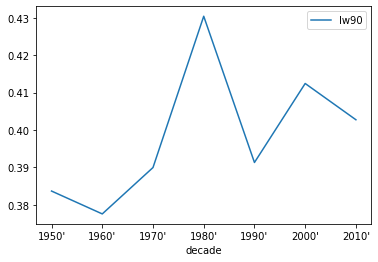

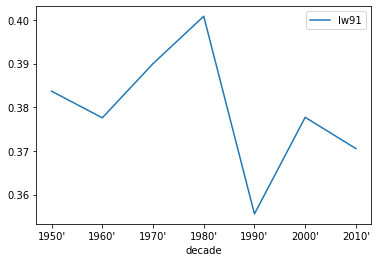

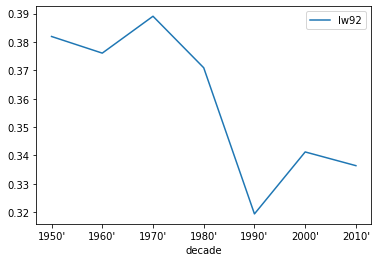

In [47]:
pd.options.mode.chained_assignment = None
new_df3 = df3[df3["month"].isin([12,1,2,3,4])]
col_list = []
for i in range(87,93):
    new_df3[f"lw{i}"]=new_df3["RF_STD"].apply(lambda x: 1 if float(x) >= i else 0)
new_df3["RH_average"]= new_df3[[f"lw{i}" for i in range(87,93)]].mean(axis=1)
new_df3= new_df3.groupby("decade").mean()
new_df3.plot( y = "RH_average")
for i in range(87,93):
    new_df3.plot( y = f"lw{i}")


### I conclude that I must really calibrate the model: the differences are huge between 87 and 93% RH so

## Negative forecast
https://journals.ametsoc.org/view/journals/apme/30/4/1520-0450_1991_030_0463_trhdff_2_0_co_2.xml

<AxesSubplot:xlabel='decade'>

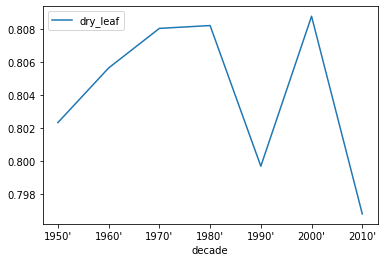

In [49]:
pd.options.mode.chained_assignment = None
new_df3 = df3[df3["month"].isin([12,1,2,3,4])]

new_df3[f"dry_leaf"]=new_df3["RF_STD"].apply(lambda x: 1 if float(x) >= 70 else 0)
#new_df3["RH_average"]= new_df3[[f"lw{i}" for i in range(87,93)]].mean(axis=1)
new_df3= new_df3.groupby("decade").mean()
#new_df3.plot( y = "RH_average")
new_df3.plot( y = "dry_leaf")